In [1]:
import pandas_patches
pandas_patches.patch()

saving apply
saving apply


In [2]:
%load_ext autoreload
%autoreload 2

In [72]:
%pylab inline
import pandas as pd
import pathlib

# import lab_tools.plot_utils as pu
# pu.load_figure_style()
#import occlusion as oc
import importlib
import matplotlib.pyplot as plt
import pickle


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import xgboost as xgb
from sklearn import pipeline
import sklearn.model_selection as sms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from stone_type_concentration_regressor import MyColTransformer
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

In [6]:
path = './pickles/data_for_nn/eem_for_parafac'
df = stc.load_data(path)

In [7]:
df_train_test = df

In [8]:
X = df_train_test[df_train_test.columns[4:]]
y = df_train_test[df_train_test.columns[1:4]]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42)

In [10]:
y

,oxalate,uric,hydroxy
0,0.000000,0.121021,0.878979
1,0.079891,0.874889,0.045221
2,0.910797,0.068004,0.021199
3,0.963773,0.036227,0.000000
4,0.928114,0.016913,0.054973
...,...,...,...
116,0.637161,0.000000,0.362839
117,0.722360,0.000000,0.277640
118,0.819858,0.101004,0.079138
119,0.855359,0.130354,0.014286


In [11]:
from tensorly.decomposition import parafac
import tensorly as tl

In [ ]:
import catboost as cb
import tensorly as tl

import tensorly as tl
from tensorly.decomposition import CP, parafac, non_negative_parafac
from tensorly.decomposition._cp import initialize_cp
from tensorly.cp_tensor import CPTensor
import time
from copy import deepcopy
import torch
tl.set_backend('pytorch')

In [14]:
import sklearn.base
from copy import deepcopy


def prepare_X(eems):
    tensor = np.array([eems[col].apply(lambda x: x.values).tolist()  for col in eems])
    return np.swapaxes(tensor, 1, 2)




class PARAFACTransformer(sklearn.base.TransformerMixin,sklearn.base.BaseEstimator):
    def __init__(self,n_components=10, non_negative=False,n_iters=100):
        self.n_components = n_components
        self.non_negative = non_negative
        self.n_iters = n_iters
        
        self.parafac = {
            True: non_negative_parafac,
            False: parafac
        }[non_negative]
        
        
        if not non_negative:
            self.extra = {'orthogonalise': True}
        else:
            self.extra = {}
            
        self.noneg = non_negative
    
        
    def fit(self,X,y=None):
        np.random.seed(42)
        parafac_matrix = X
        mask = None
        parafac_tensor = tl.tensor(parafac_matrix)
        weights_init, factors_init = initialize_cp(parafac_tensor, 
                                                   non_negative=self.non_negative,
                                                   init='random', 
                                                   rank=self.n_components,
                                                  random_state=42)

        cp_init = CPTensor((weights_init, factors_init))
        
        tensor_mu, errors_mu = self.parafac(parafac_tensor, rank=self.n_components, random_state=42,
                                                         init=deepcopy(cp_init), n_iter_max=self.n_iters,
                                                         return_errors=True, 
                                            **self.extra
                                           )

        cp_reconstruction_mu = tl.cp_to_tensor(tensor_mu)
        self.tensor_mu = tensor_mu
        
        torch.cuda.empty_cache()
        return self
    
    def transform(self,X):
        np.random.seed(42)
        parafac_matrix = X
        parafac_tensor = tl.tensor(parafac_matrix)
        
        weights = self.tensor_mu.weights
        factors = self.tensor_mu.factors[:-1]
        
        if not self.noneg:
            concs = np.random.normal(size=(X.shape[-1],self.n_components))
        else:
            concs = np.random.normal(size=(X.shape[-1],self.n_components))
            concs += -np.min(concs) + 1e-7
#             print('concs', concs)
        
        concs_tensor = tl.tensor(concs)
        factors.append(concs_tensor)
        
        cp_init_tensor = CPTensor((weights,factors))
        
        weights, transformed_factors = self.parafac(parafac_tensor,
                              self.n_components,init=deepcopy(cp_init_tensor),n_iter_max=self.n_iters,
                              fixed_modes=[0,1], random_state=42)
                

        factors = transformed_factors[-1].numpy()
        torch.cuda.empty_cache()
        
        return factors


In [15]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [65]:
import catboost
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_absolute_error as mae
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import joblib

def objective(trial):
    # boundaries for the optimizer's
    ct_pf_n_components = trial.suggest_int("ct_pf_n_components", 6, 20, step=1)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
#     ct_pca_n_components = trial.suggest_int("ct_pca_n_components", 5, 50, step=5)


    # create new model(and all parameters) every iteration
    base_model = RandomForestRegressor(
#         objective='MultiRMSE',
#         learning_rate=0.05,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,

    )

    regressor = RegressorChain(base_model)
    scaler = StandardScaler()
    ct_pf = PARAFACTransformer(n_components=ct_pf_n_components, non_negative=True, n_iters=1000)

    model = pipeline.Pipeline(

        steps = [
                ('ct_pf', ct_pf),   
                ('scaler', scaler),
                ('regressor', regressor)
        ])
    
    model.fit(prepare_X(X_train), y_train)
    y_pred = model.predict(prepare_X(X_test))
#     boot_score_test = bootstrap_metric(
#         y_test,
#         y_pred,
#         metric_fn=lambda x, y: mse(y_true=x, y_pred=y),
#     )
    
    trial.set_user_attr("train_metric", mae(y_train, model.predict(prepare_X(X_train))))
    score = mae(y_test, y_pred)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    # Сохранение лучшей модели
    if trial.number == 0 or score < trial.study.best_value:
        best_model = model
        joblib.dump(best_model, 'best_model_3comps.pkl')

    return score #boot_score.mean()


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=optuna.samplers.TPESampler()
)

study.optimize(
    objective, n_trials=1000)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

[I 2024-06-06 12:00:21,730] A new study created in memory with name: Optimizer
[I 2024-06-06 12:02:23,998] Trial 6 finished with value: 0.2415797208423931 and parameters: {'ct_pf_n_components': 6, 'n_estimators': 45, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.2216698672920484.
[I 2024-06-06 12:02:47,595] Trial 7 finished with value: 0.2466025241323845 and parameters: {'ct_pf_n_components': 19, 'n_estimators': 141, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 5 with value: 0.2216698672920484.
[I 2024-06-06 12:03:02,273] Trial 8 finished with value: 0.24862627454317512 and parameters: {'ct_pf_n_components': 10, 'n_estimators': 48, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.2216698672920484.
[I 2024-06-06 12:03:25,770] Trial 9 finished with value: 0.24518138171729406 and parameters: {'ct_pf_n_components': 16, 'n_estimators': 16, 'max_depth': 7, 'min_samp

In [66]:
loaded_model = joblib.load('best_model_3comps.pkl')

# Использование загруженной модели
y_pred_loaded = loaded_model.predict(prepare_X(X_test))
print("MAE with loaded model:", np.mean(np.abs(y_test - y_pred_loaded)))

MAE with loaded model: 0.21377938981799868


In [67]:
all_trials = study.trials_dataframe()

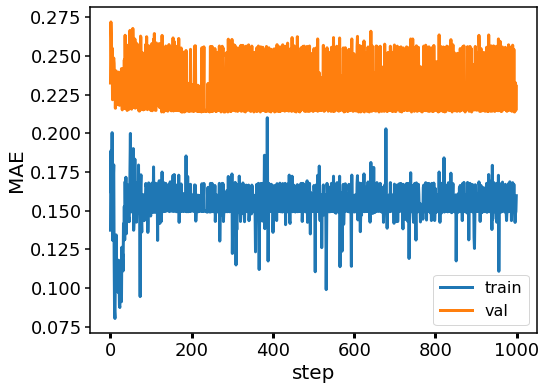

In [68]:
all_trials = study.trials_dataframe()
plot(all_trials['user_attrs_train_metric'], label='train')
plot(all_trials['value'], label='val')

plt.ylabel('MAE')
plt.xlabel('step')
plt.legend()

In [28]:
params = ['n_estimators', 'max_depth', 'ct_pf_n_components', 'min_samples_split',  'min_samples_leaf',]
optuna.visualization.plot_slice(study, params=params, target_name="mean_absolute_error")

In [69]:
study.best_params

{'ct_pf_n_components': 13,
 'n_estimators': 134,
 'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 8}

In [55]:
optuna.visualization.plot_param_importances(study)

KeyboardInterrupt: 

In [28]:
np.random.seed(42)

# Установка бэкенда NumPy для TensorLy
tl.set_backend('numpy')

In [63]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse


def mse_for_each_class(y_test, y_pred):
    classes = ['oxalate', 'urate', 'hydroxy', 'unknown']
    l, cl = y_test.shape
    for i in range(cl):
        y_test_ = y_test[:, i]
        y_pred_ = y_pred[:, i]
        mae_ = mae(y_test_, y_pred_)
        rmse_ = rmse(y_test_, y_pred_, squared=False)
        print(classes[i], 'mae:', round(mae_, 2), 'rmse:', round(rmse_, 2))
    

In [71]:
mse_for_each_class(y_test, y_pred_loaded)

oxalate mae: 0.29 rmse: 0.34
urate mae: 0.07 rmse: 0.11
hydroxy mae: 0.29 rmse: 0.36


In [44]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class ConstantRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.constant_value = None

    def fit(self, X, y):
        # Вычисляем среднее значение y в обучающем наборе
        self.constant_value = np.mean(y, axis=0)
        return self

    def predict(self, X):
        # Возвращаем константное значение для всех наблюдений
        return np.array([self.constant_value]*X.shape[0])


In [45]:
constant_reg = ConstantRegressor()
constant_reg.fit(X_train, y_train)

ConstantRegressor()

In [27]:
pred_constant = constant_reg.predict(X_test)

In [28]:
mse_for_each_class(y_test, pred_constant)

oxalate mae: 0.37 rmse: 0.4
urate mae: 0.25 rmse: 0.28
hydroxy mae: 0.32 rmse: 0.4
